### Introduction
In this project, we apply machine learning techniques, specifically K-Means clustering, to segment customers based on their purchasing behavior. The dataset used for this analysis includes information about customer demographics (such as income, marital status, and age) and their spending patterns across several product categories (e.g., wine, fruits, meat, fish, sweets, and gold products).

Objective
The primary objective of this work is to create an automated system that:

* Segments customers into different clusters based on their spending patterns.
* Predicts which cluster a new customer would belong to based on their spending behavior.
* Identify and address segments with high churn risk.
* Provides insights into customer behavior, which can help businesses tailor their marketing strategies, personalize offerings, and optimize their product placements.

In [1]:
# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Import necessary libraries
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
import seaborn as sns  
from sklearn.preprocessing import StandardScaler  
from sklearn.cluster import AgglomerativeClustering  
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
import joblib
import streamlit as st


In [4]:
# Load the dataset and view to understand its structure
df = pd.read_csv('Customer_Segmentation data.csv')

### Data Cleaning

In [6]:
# Inspecting the first few rows to understand the data structure
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [9]:
df.shape

(2240, 29)

In [12]:
#Checking for missing values
df.isnull().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

In [14]:
Customer_data = df.dropna() #droping missing values

In [16]:
Customer_data.duplicated().sum() #checking for duplicates

0

In [18]:
#Converting Dt_Customer to datetime format
Customer_data['Dt_Customer'] = pd.to_datetime(Customer_data['Dt_Customer'], format='%d-%m-%Y')

# Creating an Age column based on the Year_Birth with respect to our current year
current_year = pd.Timestamp.now().year
Customer_data['Age'] = current_year - Customer_data['Year_Birth']
Customer_data = Customer_data[Customer_data['Age'] > 0]

# Droping the Year_Birth column as it will not be needed anymore
Customer_data = Customer_data.drop(columns=['Year_Birth'])

# Dropping 'Z_CostContact' and 'Z_Revenue' as all customers have the same value, it won't add any useful information
Customer_data = Customer_data.drop(columns=['Z_CostContact', 'Z_Revenue'])

# Display the updated dataset structure
Customer_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2216 entries, 0 to 2239
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID                   2216 non-null   int64         
 1   Education            2216 non-null   object        
 2   Marital_Status       2216 non-null   object        
 3   Income               2216 non-null   float64       
 4   Kidhome              2216 non-null   int64         
 5   Teenhome             2216 non-null   int64         
 6   Dt_Customer          2216 non-null   datetime64[ns]
 7   Recency              2216 non-null   int64         
 8   MntWines             2216 non-null   int64         
 9   MntFruits            2216 non-null   int64         
 10  MntMeatProducts      2216 non-null   int64         
 11  MntFishProducts      2216 non-null   int64         
 12  MntSweetProducts     2216 non-null   int64         
 13  MntGoldProds         2216 non-null   i

In [20]:
Customer_data.head()

,ID,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,...,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age
0,5524,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,...,4,7,0,0,0,0,0,0,1,67
1,2174,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,...,2,5,0,0,0,0,0,0,0,70
2,4141,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,...,10,4,0,0,0,0,0,0,0,59
3,6182,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,...,4,6,0,0,0,0,0,0,0,40
4,5324,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,...,6,5,0,0,0,0,0,0,0,43


### Exploratory Data Analysis (EDA) and Feature Selection

In [23]:
Customer_data.describe().T #To get a concise summary of all the numerical columns


,count,mean,min,25%,50%,75%,max,std
ID,2216.0,5588.353339,0.0,2814.75,5458.5,8421.75,11191.0,3249.376275
Income,2216.0,52247.251354,1730.0,35303.0,51381.5,68522.0,666666.0,25173.076661
Kidhome,2216.0,0.441787,0.0,0.0,0.0,1.0,2.0,0.536896
Teenhome,2216.0,0.505415,0.0,0.0,0.0,1.0,2.0,0.544181
Dt_Customer,2216,2013-07-10 11:29:27.509025280,2012-07-30 00:00:00,2013-01-16 00:00:00,2013-07-08 12:00:00,2013-12-31 00:00:00,2014-06-29 00:00:00,NaN
Recency,2216.0,49.012635,0.0,24.0,49.0,74.0,99.0,28.948352
MntWines,2216.0,305.091606,0.0,24.0,174.5,505.0,1493.0,337.32792
MntFruits,2216.0,26.356047,0.0,2.0,8.0,33.0,199.0,39.793917
MntMeatProducts,2216.0,166.995939,0.0,16.0,68.0,232.25,1725.0,224.283273
MntFishProducts,2216.0,37.637635,0.0,3.0,12.0,50.0,259.0,54.752082


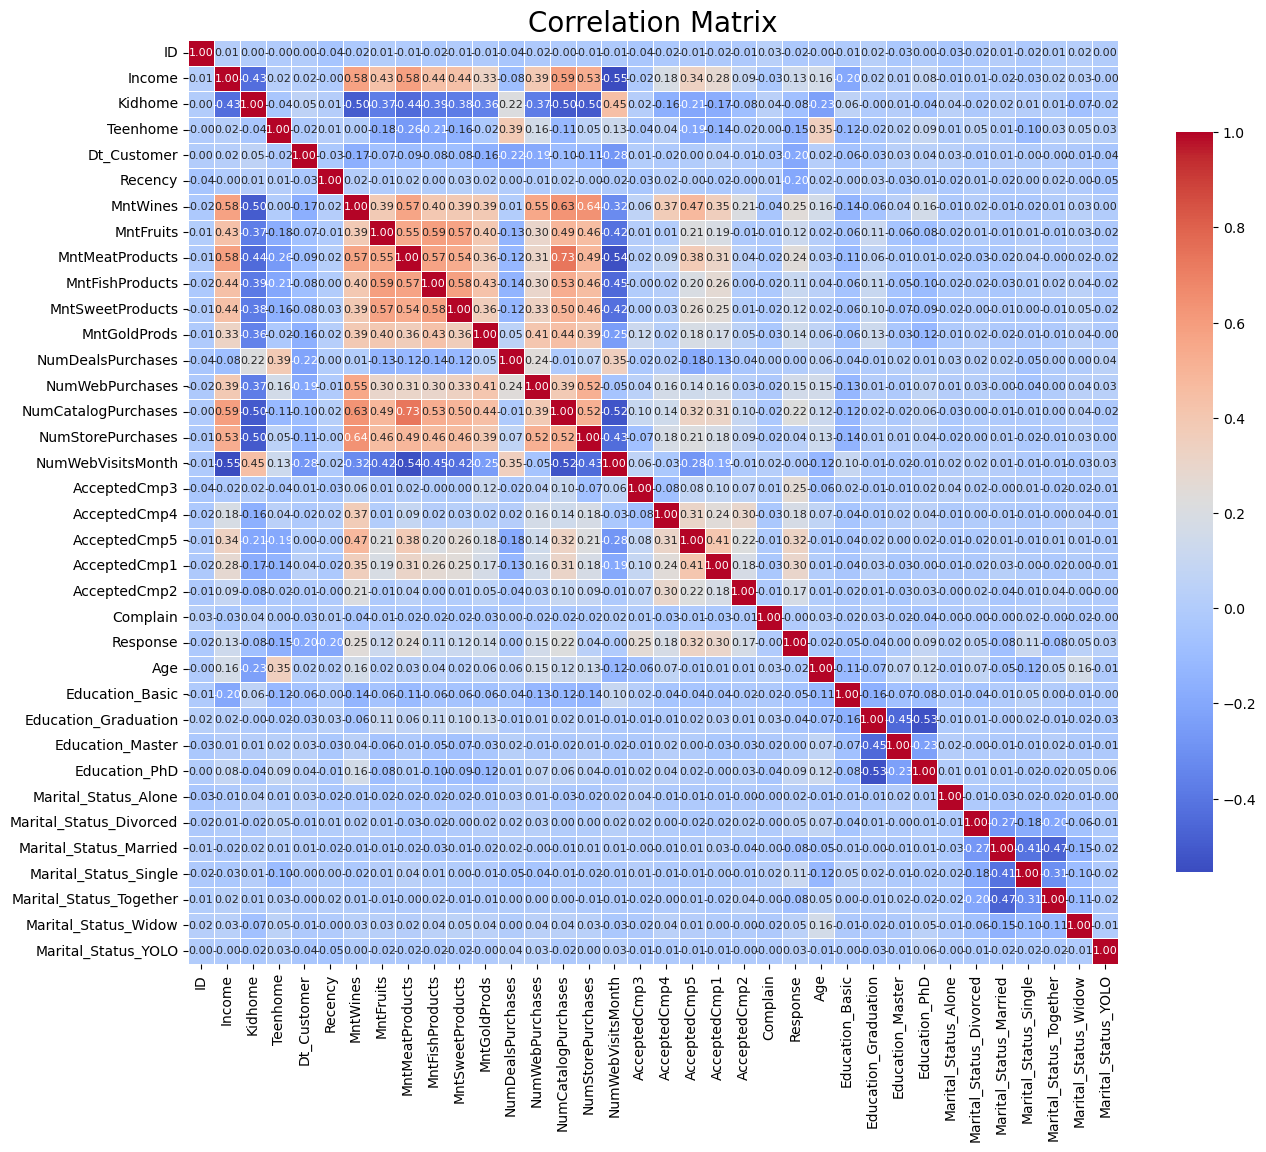

In [25]:
# Correlation Matrix
# Using One-Hot Encoding to encode the categorical columns (Education and MaritalStatus)
Customer_data_encode = pd.get_dummies(Customer_data, columns=['Education', 'Marital_Status'], drop_first=True)

correlation_matrix = Customer_data_encode.corr()
#high_corr = correlation_matrix[(correlation_matrix.abs() > 0.5)]

# Visualize the correlation heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            linewidths=0.5, cbar_kws={"shrink": 0.8}, annot_kws={"size": 8})
plt.title('Correlation Matrix', fontsize=20)
plt.show()


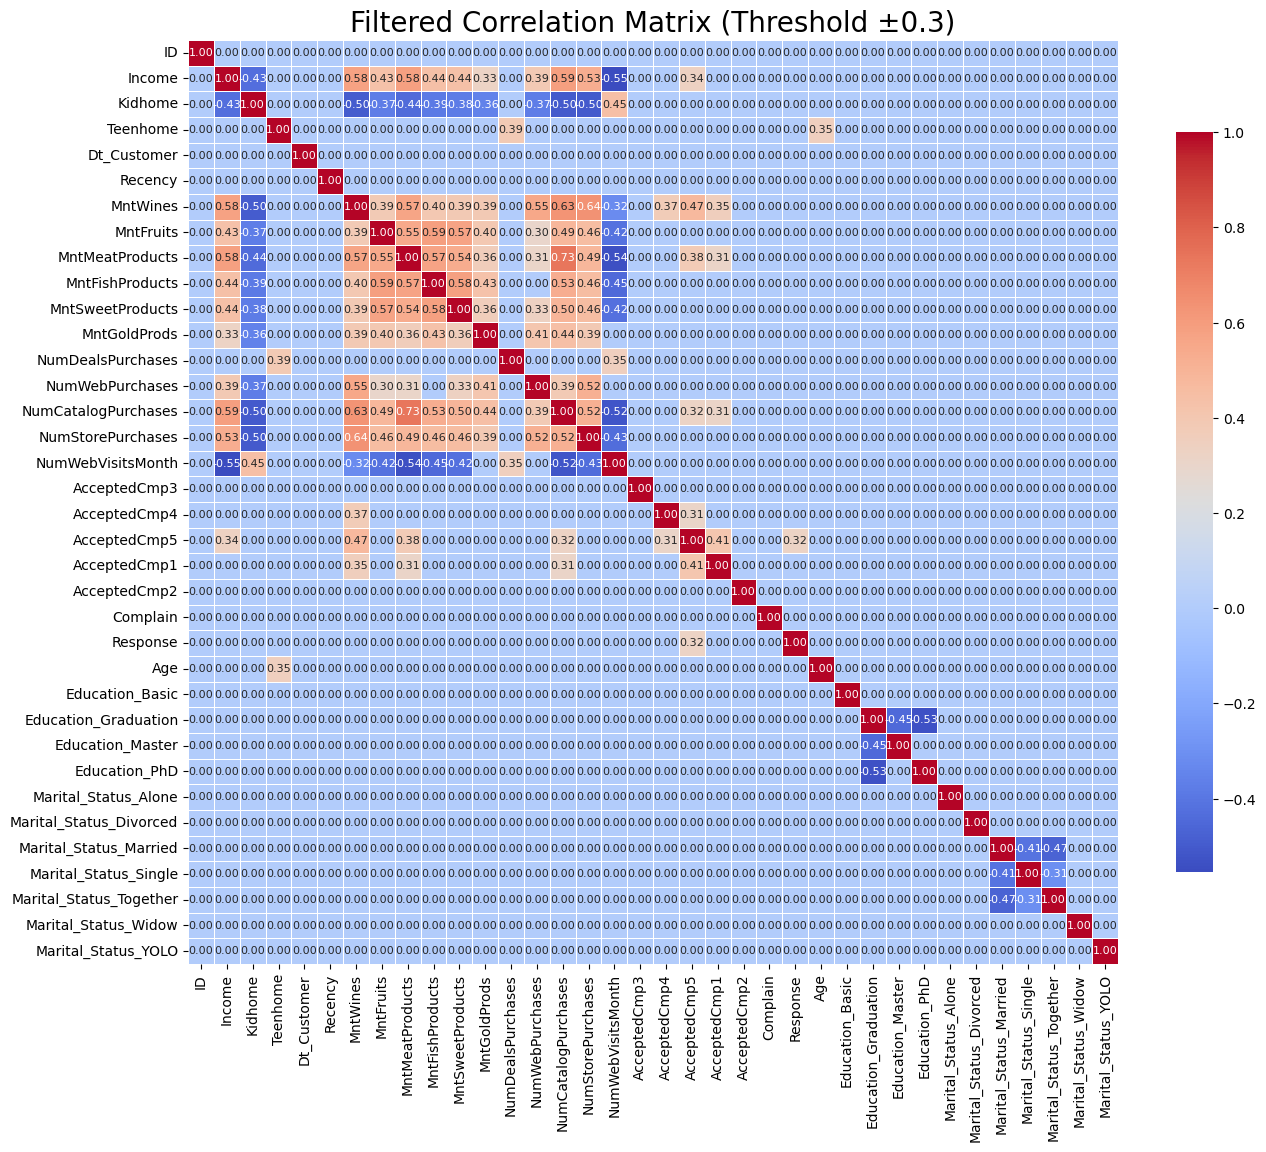

In [26]:
# Filter correlations above a certain threshold (e.g., > 0.3 or < -0.3) reduce the clutter and make the heatmap easier to interpret by focusing only on meaningful relationships.
threshold = 0.3
filtered_corr = correlation_matrix[correlation_matrix.abs() > threshold].fillna(0)

# Visualize the filtered correlation matrix
plt.figure(figsize=(15, 12))
sns.heatmap(
    filtered_corr, 
    annot=True, 
    fmt='.2f', 
    cmap='coolwarm', 
    linewidths=0.5, 
    cbar_kws={"shrink": 0.8}, 
    annot_kws={"size": 8}  # Corrected line
)
plt.title('Filtered Correlation Matrix (Threshold ±0.3)', fontsize=20)
plt.show()


In [27]:
# Using only rows with at least one strong correlation (absolute value > 0.3) with any of the spending columns.
spending_columns = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
total_spending = Customer_data[spending_columns].sum()

# Correlations of spending features with all other features
spending_corr = correlation_matrix[spending_columns]

# Display only strong correlations (e.g., > 0.3 or < -0.3)
threshold = 0.3  # Define the threshold for strong correlation
strong_spending_corr = spending_corr.loc[(spending_corr.abs() > threshold).any(axis=1)]
print("Strong Correlations with Spending Features:")
print(strong_spending_corr)


Strong Correlations with Spending Features:
                     MntWines  MntFruits  MntMeatProducts  MntFishProducts  \
Income               0.578650   0.430842         0.584633         0.438871   
Kidhome             -0.497336  -0.373396        -0.439261        -0.388884   
MntWines             1.000000   0.387024         0.568860         0.397721   
MntFruits            0.387024   1.000000         0.547822         0.593431   
MntMeatProducts      0.568860   0.547822         1.000000         0.573574   
MntFishProducts      0.397721   0.593431         0.573574         1.000000   
MntSweetProducts     0.390326   0.571606         0.535136         0.583867   
MntGoldProds         0.392731   0.396487         0.359446         0.427142   
NumWebPurchases      0.553786   0.302039         0.307090         0.299688   
NumCatalogPurchases  0.634753   0.486263         0.734127         0.532757   
NumStorePurchases    0.640012   0.458491         0.486006         0.457745   
NumWebVisitsMonth   

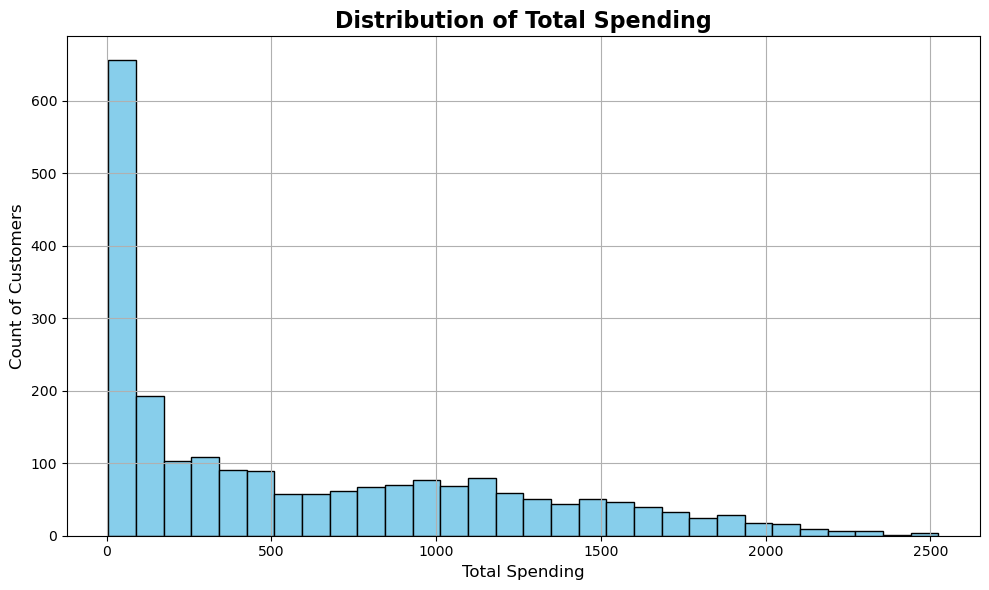

In [28]:
# Create the 'Total_Spending' feature by summing the spending columns
Customer_data['Total_Spending'] = Customer_data[spending_columns].sum(axis=1)

# Plotting the histogram of total spending
plt.figure(figsize=(10, 6))
plt.hist(Customer_data['Total_Spending'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Total Spending', fontsize=16, fontweight='bold')
plt.xlabel('Total Spending', fontsize=12)
plt.ylabel('Count of Customers', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


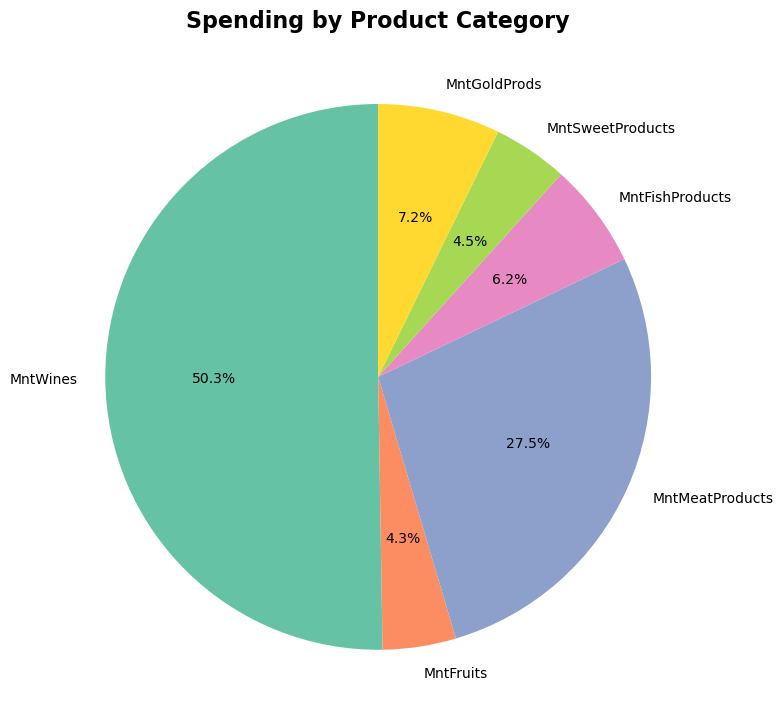

In [30]:
# Pie chart showing the proportion of total spending across the different product categories
# Sum spending across categories
category_spending = Customer_data[spending_columns].sum()

# Plotting Pie Chart for Spending Categories
plt.figure(figsize=(8, 8))
plt.pie(category_spending, labels=category_spending.index, autopct='%1.1f%%', 
        startangle=90, colors=sns.color_palette("Set2", len(category_spending)))
plt.title('Spending by Product Category', fontsize=16, fontweight='bold')
plt.ylabel('')  # Remove the y-axis label
plt.tight_layout()
plt.show()


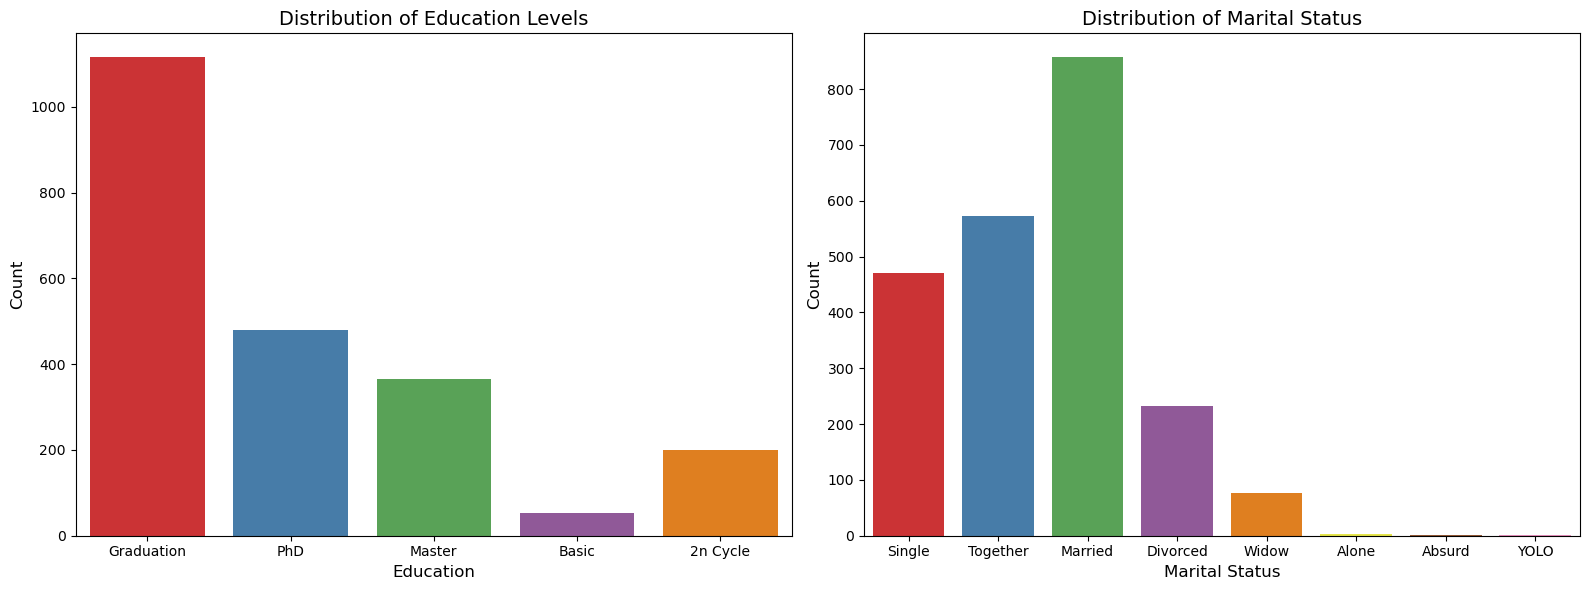

In [31]:
# Create a figure and set up subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

sns.countplot(x='Education', data=Customer_data, palette='Set1', ax=axes[0])
axes[0].set_title('Distribution of Education Levels', fontsize=14)
axes[0].set_xlabel('Education', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)

sns.countplot(x='Marital_Status', data=Customer_data, palette='Set1', ax=axes[1])
axes[1].set_title('Distribution of Marital Status', fontsize=14)
axes[1].set_xlabel('Marital Status', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)

plt.tight_layout()
plt.show()


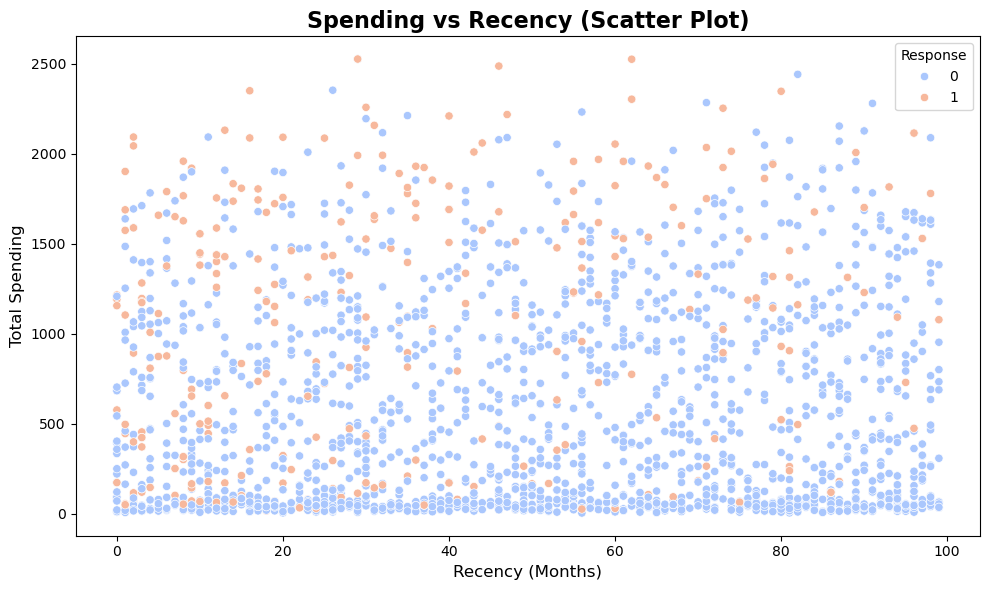

In [32]:
# Scatter plot to show how Total_Spending correlates with Recency (last interaction months)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=Customer_data, x='Recency', y='Total_Spending', hue='Response', palette='coolwarm')
plt.title('Spending vs Recency (Scatter Plot)', fontsize=16, fontweight='bold')
plt.xlabel('Recency (Months)', fontsize=12)
plt.ylabel('Total Spending', fontsize=12)
plt.tight_layout()
plt.show()


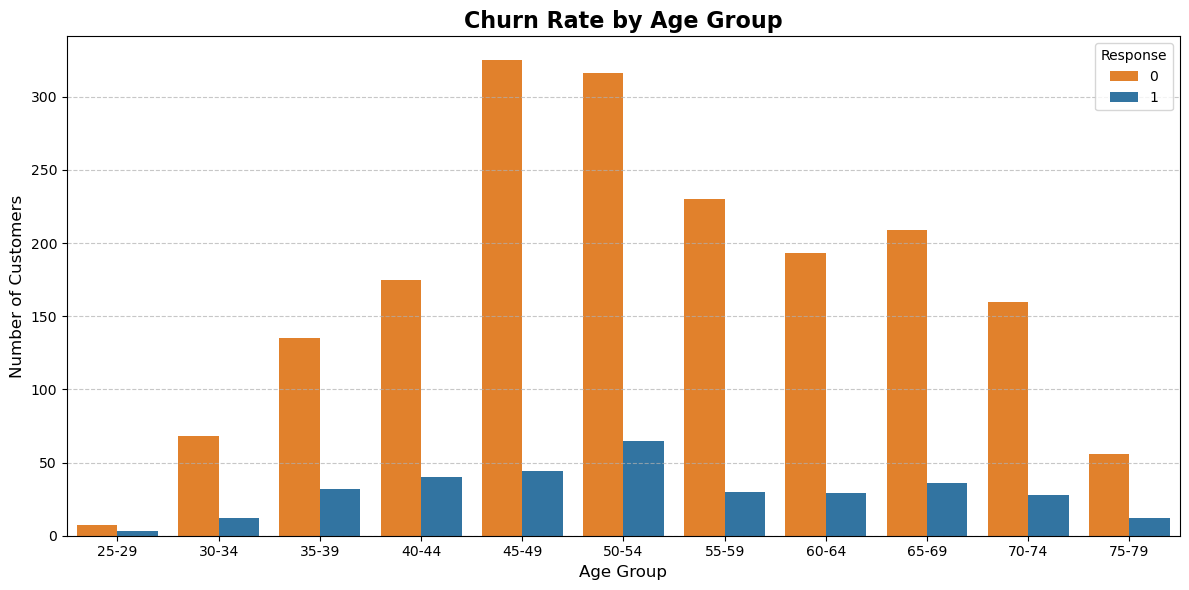

In [33]:
# Create age groups to reduce x-axis clutter
Customer_data['Age_Group'] = pd.cut(Customer_data['Age'], bins=range(25, 85, 5), labels=[f"{i}-{i+4}" for i in range(25, 80, 5)])

# Plot grouped bar chart
plt.figure(figsize=(12, 6))
sns.countplot(data=Customer_data, x='Age_Group', hue='Response', palette=['#FF7F0E', '#1F77B4'], dodge=True)
plt.title("Churn Rate by Age Group", fontsize=16, fontweight='bold')
plt.xlabel("Age Group", fontsize=12)
plt.ylabel("Number of Customers", fontsize=12)
plt.legend(title="Response", loc='upper right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


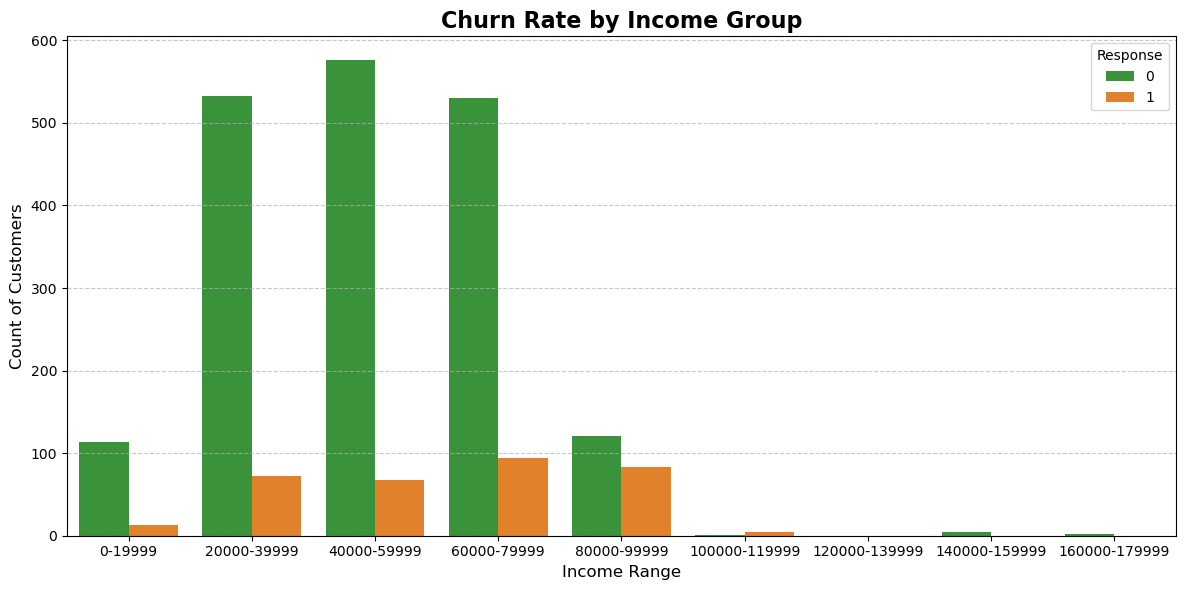

In [34]:
# Creating income bins to group customers into broader income ranges
Customer_data['Income_Group'] = pd.cut(Customer_data['Income'], 
                                       bins=range(0, 200000, 20000),  # Adjusting ranges (e.g., 0-20k, 20k-40k, etc.)
                                       labels=[f"{i}-{i+19999}" for i in range(0, 180000, 20000)])

# Plot grouped bar chart for churn by income group
plt.figure(figsize=(12, 6))
sns.countplot(data=Customer_data, x='Income_Group', hue='Response', 
              palette=['#2ca02c', '#ff7f0e'], dodge=True)

plt.title("Churn Rate by Income Group", fontsize=16, fontweight='bold')
plt.xlabel("Income Range", fontsize=12)
plt.ylabel("Count of Customers", fontsize=12)
plt.legend(title="Response", loc='upper right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


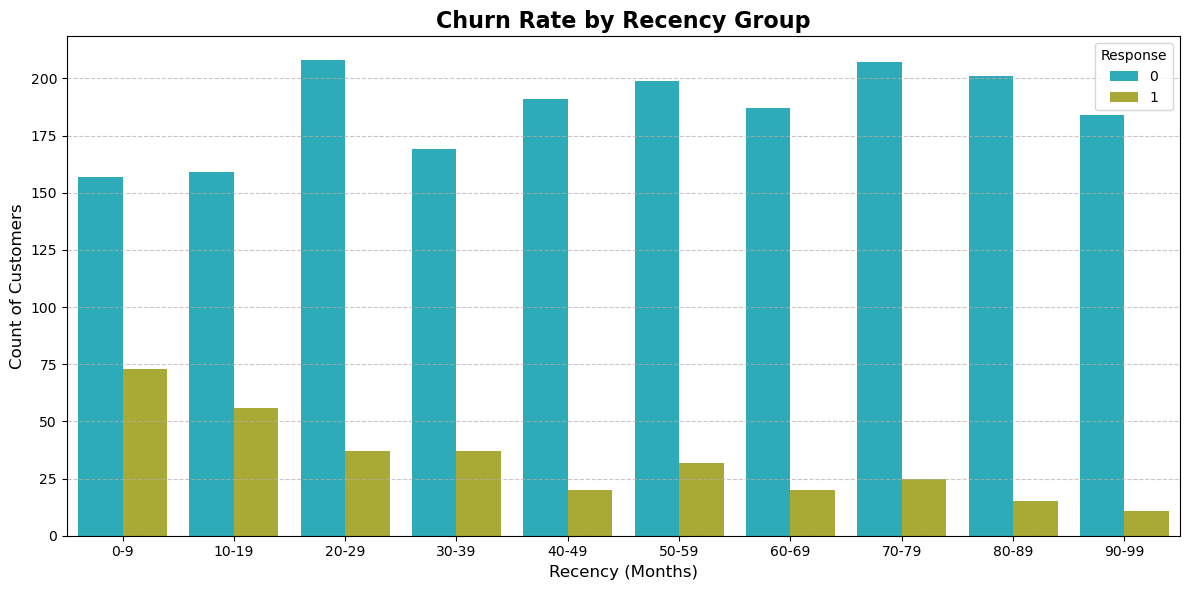

In [37]:
# Creating bins for recency (e.g., group by intervals of 10 months)
Customer_data['Recency_Group'] = pd.cut(Customer_data['Recency'], 
                                        bins=range(0, 110, 10),  # Bins for intervals of 10 (e.g., 0-9, 10-19, ...)
                                        labels=[f"{i}-{i+9}" for i in range(0, 100, 10)])

# Plot grouped bar chart for churn by recency group
plt.figure(figsize=(12, 6))
sns.countplot(data=Customer_data, x='Recency_Group', hue='Response', palette=['#17becf', '#bcbd22'], dodge=True)

plt.title("Churn Rate by Recency Group", fontsize=16, fontweight='bold')
plt.xlabel("Recency (Months)", fontsize=12)
plt.ylabel("Count of Customers", fontsize=12)
plt.legend(title="Response", loc='upper right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [45]:
# Using Mutual information to measures the dependency between two variables
from sklearn.feature_selection import mutual_info_regression

# Select relevant numerical features
numerical_features = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'Age', 'Income']

# Get the features (X) and target (y)
X = Customer_data[numerical_features]
y = Customer_data['Total_Spending']

# Calculating mutual information between features and target
mutual_info = mutual_info_regression(X, y)

# Creating a DataFrame to view the mutual information scores
mutual_info_df = pd.DataFrame({'Feature': numerical_features, 'Mutual Information': mutual_info})
mutual_info_df = mutual_info_df.sort_values(by='Mutual Information', ascending=False)

mutual_info_df


,Feature,Mutual Information
0,MntWines,1.205744
2,MntMeatProducts,1.168693
5,MntGoldProds,0.744315
7,Income,0.742499
3,MntFishProducts,0.681411
4,MntSweetProducts,0.631359
1,MntFruits,0.624995
6,Age,0.101418


In [47]:
# Using Random Forest to assess feature importance
from sklearn.ensemble import RandomForestRegressor

# Define the features (X) and target (y)
X = Customer_data[numerical_features]
y = Customer_data['Total_Spending']

# Create a RandomForestRegressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model to the data
rf_model.fit(X, y)

# Get the feature importance scores
feature_importance = rf_model.feature_importances_

# Creating a DataFrame to view the feature importance
feature_importance_df = pd.DataFrame({'Feature': numerical_features, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

feature_importance_df


,Feature,Importance
2,MntMeatProducts,0.616643
0,MntWines,0.356533
3,MntFishProducts,0.009571
5,MntGoldProds,0.005100
1,MntFruits,0.004971
4,MntSweetProducts,0.004890
7,Income,0.001427
6,Age,0.000864


In [49]:
# List of selected relevant features based on mutual information and feature importance
selected_features = ['MntWines', 'MntMeatProducts', 'MntGoldProds', 'MntFishProducts', 'Income']

# Extracting the relevant features from the dataset
X_selected = Customer_data[selected_features]

X_selected.head()


,MntWines,MntMeatProducts,MntGoldProds,MntFishProducts,Income
0,635,546,88,172,58138.0
1,11,6,6,2,46344.0
2,426,127,42,111,71613.0
3,11,20,5,10,26646.0
4,173,118,15,46,58293.0


### Model training and testing

In [52]:
# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

# Saving the scaler
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']

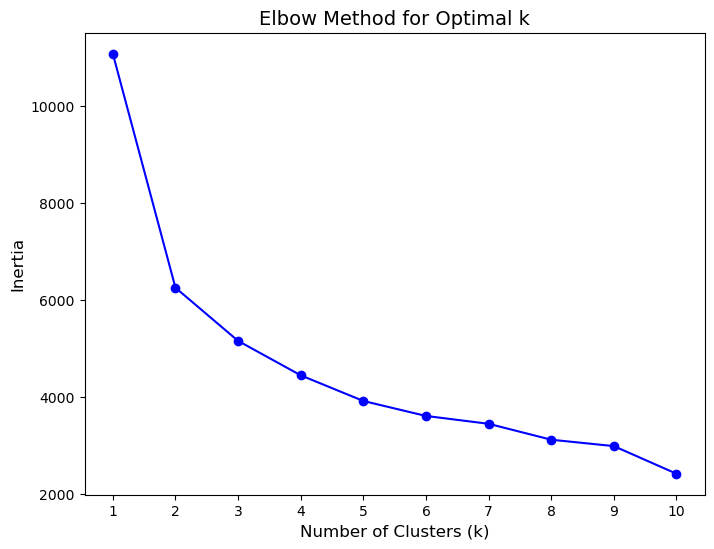

In [54]:
# Calculate the Sum of Squared Distances (Inertia) for different numbers of clusters
inertia = []
for k in range(1, 11):  # Testing k from 1 to 10
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o', color='b')
plt.title('Elbow Method for Optimal k', fontsize=14)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Inertia', fontsize=12)
plt.xticks(range(1, 11))
plt.show()


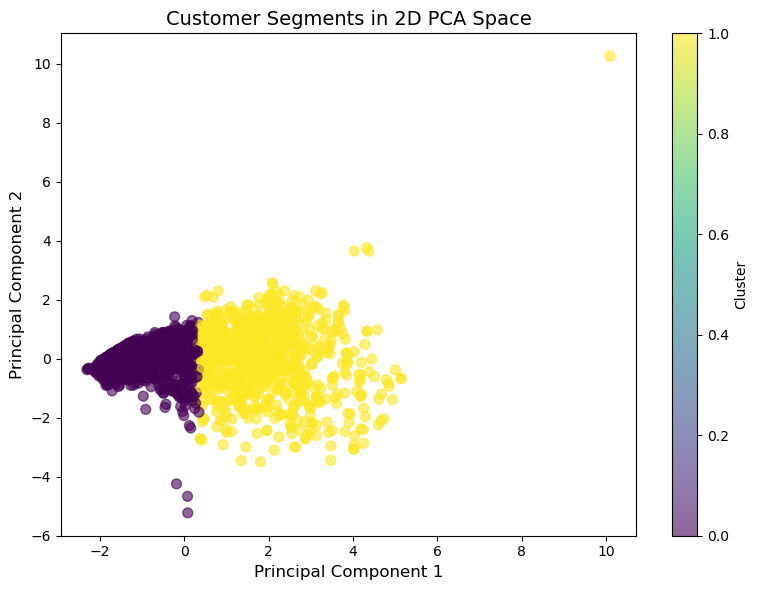

In [55]:
# Applying KMeans clustering using the optimal number of clusters identified from the elbow plot.
kmeans = KMeans(n_clusters=2, random_state=42)

# Fitting the KMeans model and assigning clusters
Customer_data['Cluster'] = kmeans.fit_predict(X_scaled)

from sklearn.decomposition import PCA

# Performing PCA to reduce the data to 2 components for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Scatter plot for the clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=Customer_data['Cluster'], cmap='viridis', s=50, alpha=0.6)
plt.title('Customer Segments in 2D PCA Space', fontsize=14)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.colorbar(label='Cluster')
plt.tight_layout()
plt.show()


In [58]:
# Predicting clusters for new customers
# Creating 'new_customer_data' DataFrame containing new customer data with the same features as the training set
new_customer_data = pd.DataFrame({
    'MntWines': [120, 450],  # Example data for new customers
    'MntMeatProducts': [100, 200],
    'MntGoldProds': [150, 250],
    'MntFishProducts': [40, 50],
    'Income': [50000, 75000]
})

# Reorder new_customer_data columns to match selected_features order
new_customer_data = new_customer_data[selected_features]

# Scale the new customer data using the same scaler
new_customer_data_scaled = scaler.transform(new_customer_data)

# Predict clusters for new customers
new_customer_clusters = kmeans.predict(new_customer_data_scaled)

# Adding the predicted clusters to the new customer data
new_customer_data['Predicted_Cluster'] = new_customer_clusters

# View the new customer data with predicted clusters
new_customer_data


,MntWines,MntMeatProducts,MntGoldProds,MntFishProducts,Income,Predicted_Cluster
0,120,100,150,40,50000,0
1,450,200,250,50,75000,1


In [60]:
# Summarizing the cluster characteristics by calculating the mean of each feature for each cluster
cluster_summary = Customer_data.groupby('Cluster')[selected_features].mean()

# Including the size of each cluster to understand the distribution
cluster_summary['Size'] = Customer_data['Cluster'].value_counts()

cluster_summary


,MntWines,MntMeatProducts,MntGoldProds,MntFishProducts,Income,Size
Cluster,,,,,,
0,109.439327,40.537281,21.708333,10.532164,39268.658626,1368
1,620.719340,371.000000,79.870283,81.364387,73184.415094,848


In [62]:
# Silhouette Score Calculation to evaluate the quality of the clusters
from sklearn.metrics import silhouette_score

sil_score = silhouette_score(X_scaled, Customer_data['Cluster'])
print(f'Silhouette Score: {sil_score}')


Silhouette Score: 0.47464569336501966


### Model deployment and monitoring

In [64]:
# Saving the KMeans model
joblib.dump(kmeans, 'kmeans_model.pkl')

# Saving the scaler
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']

In [66]:
# Create the file Customer_segmentation_Prediction_Streamlit_App.py in write mode
with open("Customer_segmentation_Prediction_Streamlit_App.py", "w") as file:
    # Writing the Streamlit code into the file
    file.write("""
import streamlit as st
import joblib
import pandas as pd

# Load the trained models
kmeans = joblib.load('kmeans_model.pkl')  # Load KMeans model
scaler = joblib.load('scaler.pkl')  # Load StandardScaler

# Define the selected features in the same order as the training data
selected_features = ['MntWines', 'MntMeatProducts', 'MntGoldProds', 'MntFishProducts', 'Income']

# Streamlit app to accept input from the user
st.title('Customer Segmentation')

# Collecting input data for new customers
mnt_wines = st.number_input('MntWines', min_value=0, max_value=1000)
mnt_meat_products = st.number_input('MntMeatProducts', min_value=0, max_value=1000)
mnt_gold_prods = st.number_input('MntGoldProds', min_value=0, max_value=1000)
mnt_fish_products = st.number_input('MntFishProducts', min_value=0, max_value=1000)
income = st.number_input('Income', min_value=1000, max_value=200000)

# Create a DataFrame for the new customer data
new_customer_data = pd.DataFrame({
    'MntWines': [mnt_wines],
    'MntMeatProducts': [mnt_meat_products],
    'MntGoldProds': [mnt_gold_prods],
    'MntFishProducts': [mnt_fish_products],
    'Income': [income]
})

# Ensure the data has the same feature order as the training set
new_customer_data = new_customer_data[selected_features]

# Scale the new customer data using the same scaler
new_customer_data_scaled = scaler.transform(new_customer_data)

# Predict clusters for new customers
new_customer_clusters = kmeans.predict(new_customer_data_scaled)

# Adding the predicted cluster to the new customer data
new_customer_data['Predicted_Cluster'] = new_customer_clusters

# Display the new customer data with predicted clusters
st.write('Predicted Cluster for New Customer:')
st.write(new_customer_data)
""")
